In [40]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
import tkinter as tk

from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)

In [2]:
# Some useful constants (in cm) for SK

zMin = - 1818.92
zMax = 1818.92
cylinderRadius = 1697.43
PMTRadius = 25.4

In [3]:
def project2d(x, y, z) :
  N = len(x)
  xproj = []
  yproj = []
  eps = 0.01
  for i in range(N) :
    if z[i] < zMax - eps and z[i] > zMin + eps :
      azimuth = np.arctan2(y[i], x[i])
      if azimuth < 0:
        azimuth = 2 * np.pi + azimuth
      xproj.append(cylinderRadius * (azimuth - np.pi))
      yproj.append(z[i])
    elif z[i] > zMax - eps :
      xproj.append(- y[i])
      yproj.append(x[i] + zMax + cylinderRadius)
    else :
      xproj.append(- y[i])
      yproj.append(- x[i] + zMin - cylinderRadius)
  return np.array(xproj),np.array(yproj)


def rescale_color(x) : # rescale colors with sigmoid to have better resolution
  if len(x)>1 :
    return 1 / (1 + np.exp(-(x-np.mean(x))/np.std(x))) # sigmoid
  return x


def plot_2D(xproj,yproj,charge) :

    fig, ax = plt.subplots(figsize=(12, 12))

    ax.set_xlim(-np.pi*cylinderRadius - 100, np.pi*cylinderRadius + 100) 
    ax.set_ylim(zMin - 2*cylinderRadius - 100, zMax + 2*cylinderRadius + 100)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    dpi = fig.get_dpi()
    fig_width, fig_height = fig.get_size_inches() * dpi
    x_points_per_data_unit = fig_width / (xlim[1] - xlim[0])
    y_points_per_data_unit = fig_height / (ylim[1] - ylim[0])

    avg_points_per_data_unit = (x_points_per_data_unit + y_points_per_data_unit) / 2

    sizes_in_points2 = (PMTRadius * avg_points_per_data_unit) ** 2


    ax.add_patch(plt.Rectangle((-np.pi*cylinderRadius,zMin), 2*np.pi*cylinderRadius, 2*zMax,fill=False))
    ax.add_patch(plt.Circle((0, zMax+cylinderRadius), cylinderRadius,fill=False))
    ax.add_patch(plt.Circle((0, zMin-cylinderRadius), cylinderRadius, fill=False))
    ax.scatter(xproj, yproj, c=charge, s=sizes_in_points2, cmap='plasma')
    ax.set_aspect('equal')

In [43]:
events = up.open('./Events/30_mu-_1000MeV_GPS_clean.root')['wcsimT']
events.keys()

['vtx',
 'vtx0',
 'n_hits',
 'hitx',
 'hity',
 'hitz',
 'charge',
 'time',
 'eventType']

In [49]:
events['hitx']

<TBranch 'hitx' at 0x7f7977cc7880>

In [57]:
X = events['hitx'].array(library='np')

In [61]:
X[0]

array([  388.85  ,  1012.3293, -1690.0946, ...,  1067.3901,  1012.3293,
       -1316.4619], dtype=float32)

In [53]:
events['hitz'].array()

<Array [[1.82e+03, 910, ..., 210, 1.33e+03], ...] type='30 * var * float32'>

In [72]:
A = np.array([project2d(events['hitx'].array()[i], events['hity'].array()[i], events['hitz'].array()[i]) for i in range(len(events['hitx'].array()))], dtype=object)

In [73]:
X2D = A[:,0]

In [76]:
len(X2D[0])

2234

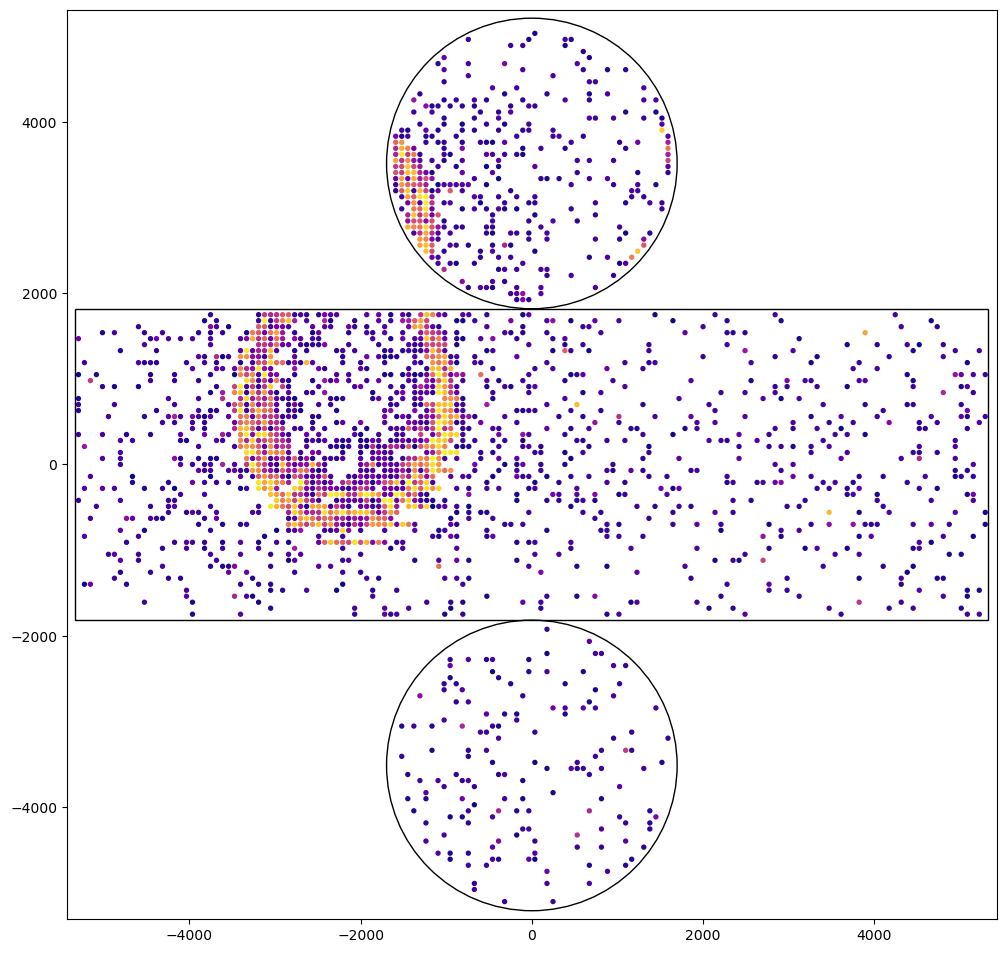

In [6]:
# plot a given event 

event_index = 13

x, y, z = events['hitx'].array()[event_index], events['hity'].array()[event_index], events['hitz'].array()[event_index]
c = events['charge'].array()[event_index]
t = events['time'].array()[event_index]

xproj, yproj = project2d(x, y, z)

plot_2D(xproj, yproj, rescale_color(c))

In [42]:
len(x)

2218

In [35]:
def showTime(data): #plot event display with tkinter animation

  data=data[data[:,-1].argsort()]
  X, Y, Z, charge, time = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
  fig = plt.figure()
  ax = plt.axes()
  xproj,yproj = project2d(X,Y,Z)

  def plot(string): #plot command to be called by tkinter slider
    ax.clear()
    ax.set_xlim(-np.pi*cylinderRadius,np.pi*cylinderRadius)
    ax.set_ylim(zMin-2*cylinderRadius,zMax+2*cylinderRadius)
    ax.set_aspect('equal')
    plt.gca().add_patch(plt.Rectangle((-np.pi*cylinderRadius,zMin),2*np.pi*cylinderRadius,2*zMax,fill=False))
    plt.gca().add_patch(plt.Circle((0,zMax+cylinderRadius),cylinderRadius,fill=False))
    plt.gca().add_patch(plt.Circle((0,zMin-cylinderRadius),cylinderRadius,fill=False))
    t = w1.get()
    dataT = data[data[:,-1]<=t]
    x, y, z, c = dataT[:,0], dataT[:,1], dataT[:,2], rescale_color(dataT[:,3])
    xprojT,yprojT = project2d(x,y,z)
    plt.scatter(xprojT,yprojT,c=c,marker='.',edgecolors='none')
    canvas.draw()

  # defining tkinter window ==========================
  root = tk.Tk()
  root.wm_title("Event Display")

  # embedding matplotlib figure in tkinter window ==============
  canvas = FigureCanvasTkAgg(fig, master=root)  # A tk.DrawingArea.
  canvas.draw()
  canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
  toolbar = NavigationToolbar2Tk(canvas, root)
  toolbar.update()

  # time slider =======================================================
  w1 = tk.Scale(root, resolution = (time[-1]-time[0])/100000, from_=time[0], to=time[-1], orient=tk.HORIZONTAL, command=plot) #c
  w1.pack()
  tk.Label(root, text = "time").pack()

  def _quit():
      root.quit()
      root.destroy()

  root.protocol("WM_DELETE_WINDOW", _quit)    
  plot('0')
  root.mainloop()


In [41]:
data = np.array(np.column_stack((x, y, z, c, t)))

showTime(data)

TclError: no display name and no $DISPLAY environment variable